# *Nb #3* - Memory management: shedding off excess time


## Introduction

Up to now we have learned how to write a kernel function and how to efficiently run it. Our input data progressed together with our knowledge as we switched from a 1D sampled signal to a 2D image array at the input / output of our kernel. Now it's time to go back to 1D data samples, while still potentially leveraging a 2D grid of threads. We will also look at how we can recycle existing threads and use them in different contexts within the same kernel. However, before we do so there is still one elephant in the room that is keeping our kernel functions from reaching their full potential - memory management.

## First steps towards optimal memory access

### What goes on in the background?

At the end of the third assignment there was a hint regarding the first step of memory management. Calling the statement `cuda.to_device()` enables us to allocate memory on the GPU and enjoy short read/write times, instead of always passing CPU-based arrays to the kernel function. One can think of it as a `malloc()` statement in C, with the host being the GPU's RAM. Judging by the below figure, transferring the entire array only once to and from the GPU is far more efficient than constantly referencing objects in the CPU's working memory. Moreover, if numerous therads access the data bus at the same time, the bus becomes a bottleneck, stalling any processing instructions and increasing the time delays.

Keep in mind that Numba does implement conservative memory transfers in the background. These take place during kernel invocation, initially transferring memory to the GPU and back to the CPU once the kernel finishes. However, in certain cases it's more rewarding to keep the data on the GPU in between multiple computations.

<img src="./Image/cuda-workflow.png" alt="CUDA workflow." style="width: 500px; padding: 20px"/>

### Simple memory management in practice

Let's revisit the 2D histogram kernel from last time, re-measure its execution time, and see how simple memory migration will improve our GPU code. Run the below to import the relevant code and check that everything is working.

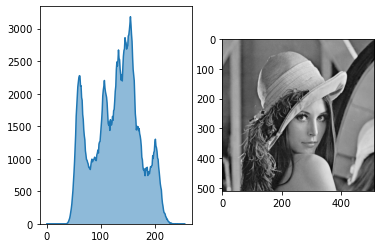

In [5]:
from numba import cuda
import numpy as np
from matplotlib import pyplot as plt

from Helpers import synchronous_kernel_timeit, get_lenna, kernel_2D


_, image_array_gs = get_lenna() # Get the test images in ndarray form

xmin, xmax = (0, 255)
nbins = 255

# Reset histogram
histogram_out = np.zeros(nbins)

# Wrap kernel funciton call and save to variable for later usage
histogram_Lenna = lambda: kernel_2D[(4, 4), (16, 16)](image_array_gs, xmin, xmax, histogram_out)
histogram_Lenna()

# Calculate x-axis values for plotting reasons (we also need to recalculate the bin width)
bin_width = (xmax - xmin) / nbins
x_vals = np.linspace( xmin, xmax, nbins, endpoint=False ) + bin_width/2

# Plot the histogram and image
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.bar( x_vals, histogram_out, width=bin_width, alpha=0.5 )
ax1.plot( x_vals, histogram_out )
ax2.imshow(image_array_gs, cmap='gray')
plt.show()

Let's refresh out memory and time the function again

In [6]:
t_histogram = synchronous_kernel_timeit( histogram_Lenna, number=100 )
print(t_histogram)

0.006026015281677246


Now migrate part of the data to the **GPU's (device's) global memory** before running the kernel. In this example, we are still timing some memory access operations, but the largest portion of data has been copied to the GPU. The memory allocation and copying are both achieved by calling `cuda.to_device()`.

In [7]:
import time

from numba import cuda

image_array_gs_device = cuda.to_device(image_array_gs)

histogram_Lenna_dev = lambda: kernel_2D[(4, 4), (16, 16)](image_array_gs_device, xmin, xmax, histogram_out)
t_histogram_dev = synchronous_kernel_timeit( histogram_Lenna_dev, number=100 )
print(t_histogram_dev)

0.0036136746406555177


Faster. We can observe that a considerable amount of time is consumed for **accessig data in the CPU's (host's) RAM**. However, the memory migration also induces a time delay. Let's evaluate that next:

In [8]:
start = time.time()
t_mem = synchronous_kernel_timeit( lambda: cuda.to_device(image_array_gs), number=100 )
print("Time needed fo read-only memory migration (s)", t_mem)
print("Sum of memory migration and processing times (s)", t_mem + t_histogram_dev)

Time needed fo read-only memory migration (s) 0.0014942502975463868
Sum of memory migration and processing times (s) 0.005107924938201905


### Increasing the gains: chaining functions

So, timing the kernel that uses the pre-allocated memory yields a better result, but the total time stays rougly the same. Memory migration starts outpacing unoptimized code when a chain of operations on the GPU uses the same data. Let's look at the following example:

1. The input image gets inverted
2. The inverse is flattened
3. The histogram of the flattened image is calculated

Step by step, the below cells calculate the individual contributions with and without memory migration. 

First, processing the inverse:

In [ ]:
from Helpers import invert_image

image_array_gs_inv = np.empty_like(image_array_gs)

inversion_Lenna = lambda: invert_image[(4, 4), (16, 16)](image_array_gs, image_array_gs_inv)
t_inversion = synchronous_kernel_timeit( inversion_Lenna, number=100 )
print(t_inversion)

In [ ]:
image_array_gs_inv_device = cuda.to_device(image_array_gs)

inversion_Lenna_dev = lambda: invert_image[(4, 4), (16, 16)](image_array_gs_device, image_array_gs_inv_device)
t_inversion_dev = synchronous_kernel_timeit( inversion_Lenna_dev, number=100 )
print(t_inversion_dev)

Next up the flattening of the image, using the inverted image as input:

In [ ]:
from Helpers import flatten_image

image_array_gs_flat = np.zeros(image_array_gs.shape)

flatten_Lenna = lambda: flatten_image[(4, 4), (16, 16)](image_array_gs_inv, image_array_gs_flat)
t_flatten = synchronous_kernel_timeit( flatten_Lenna, number=100 )
print(t_flatten)

In [ ]:
image_array_gs_flat_device = cuda.to_device(image_array_gs_flat)

flatten_Lenna_dev = lambda: flatten_image[(4, 4), (16, 16)](image_array_gs_inv_device, image_array_gs_flat_device)
t_flatten_dev = synchronous_kernel_timeit( flatten_Lenna_dev, number=100 )
print(t_flatten_dev)

And finally sum the individual contributions to see how much time the execution of such a program would take on average. Taking the previously established histogram and memory migration timing results yields:

In [ ]:
print("Without memory management (s):", t_histogram + t_inversion + t_flatten)
print("Using basic memory management (s):", t_mem + t_histogram_dev + t_inversion_dev + t_flatten_dev)

Recall that during the previous assignments, we saw the GPU doesn't always outpace the CPU, even in easily paralellizable code execution. The above results hint as to why that is the case. In fact, **the GPU performs well when there is a single migration of a dataset, followed by a the successive execution of complex, potentially iterative, and paralellizable algorithms.** 

When frequent read/write operations are needed on small portions of data that is updated by other processes in real-time, then the CPU might be a better option. There is no magic formula. When possible, consider the pros and cons of all available architectures, run some initial tests, and go for the best performing option.

Lastly, let's see the results of the timed code:

In [ ]:
# Reset and compute all values
histogram_out = np.zeros(nbins)
#histogram_Lenna_dev()
inversion_Lenna_dev()
flatten_Lenna_dev()
kernel_2D[(4, 4), (16, 16)](image_array_gs_flat_device, xmin, xmax, histogram_out)

# Plot the results
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(12,4))
plt.subplots_adjust(left=0, top=1, right=1, bottom=0, wspace=0.5)
ax1.imshow(image_array_gs, cmap='gray'); ax1.set_title('Reference image')
ax2.imshow(image_array_gs_inv, cmap='gray'); ax2.set_title('Invert')
ax3.imshow(image_array_gs_flat, cmap='gray', vmin=0, vmax=255); ax3.set_title('Flatten')
ax4.bar( x_vals, histogram_out, width=bin_width, alpha=0.5 )
ax4.plot( x_vals, histogram_out ); ax4.set_title('Histogram')
plt.show()

## Memory tiers

### Spoiled for choice

Of ocurse there isn't just one memory type that we can access on the GPU. Luck has it we are quite flexible in the way we choose which memory we use and when. In fact, there are six different tiers of memory on the GPU at the disposal of its threads. The ones we are concerted with are: global memory (GMEM), constant memory (CMEM), and shared memory (SMEM). 

<img src="./Image/memory-table.png" alt="CUDA memory table." style="width: 800px; padding: 20px"/>

Both GMEM and SMEM reside somewhat further away from the the stream multiprocessor (SM), and therefore the CUDA cores, while the SMEM is present on the SM itself and is therefore adjacent to the CUDA cores. Its downside is that it's limited in size. Only 48 kB on the GT 730. That's less than the size of a 128x128 px RGB (8 bit color), so we need to be frugal in the way we use it. If we only need to read the data, then CMEM is a better option. It has more space at its disposal, and although its positioned further away from the SM, a portion of it is autmatically cached on the SM. Lastly, for large amounts of data and flexible read/write operations, GMEM is the way to go.

<img src="./Image/memory-architecture.png" alt="CUDA architecture." style="width: 600px; padding: 20px"/>

### Using more memory tiers in practice

Redefining the kernel to support the additional memory types is a slightly more tedious process. The below kernel definition roughly does the following:
1. Define constant (entire GPU) and shared memory (per block), together with the already familiar thread indexes and strides
2. Set the shared memory to zeros
3. **Synchronize** threads in block
4. Execute te known histogram function
5. **Synchronize** threads in block
6. Migrate the data from shared back to global memory

In [ ]:
from numba import cuda, types


NBINS = 255 # Defined in advance for the allocation of SMEM
            
            
@cuda.jit
def kernel(samples, xmin, xmax, histogram_out):
    '''Use the GPU for generateing a histogram of 2D input data.'''

    # Transfer the samples into CMEM and initialize SMEM
    CMEM = cuda.const.array_like(samples) # In general, for all blocks
    smem = cuda.shared.array(shape=NBINS, dtype=types.uint32) # Per-block

    # Calculate the thread's absolute position within the grid
    x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    y = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    # Set stride equal to the number of threads we have available in either direction
    stride_x = cuda.gridDim.x * cuda.blockDim.x
    stride_y = cuda.gridDim.y * cuda.blockDim.y

    # Calc the resolution of the histogram
    bin_width = (xmax - xmin) / NBINS

    
    # Initialize the SMEM array to zeros
    if cuda.threadIdx.y == 0: # Execute only once per block (SMEM scope)
        for i in range(cuda.threadIdx.x, NBINS, cuda.blockDim.x): # Stride on a per-block basis till NBINS is reached
            smem[i] = 0

            
    cuda.syncthreads() # Wait for initialization

    
    for i in range(x, CMEM.shape[0], stride_x):
        for j in range(y, CMEM.shape[1], stride_y):
            # Associate each sample in the interval [xmin, xmax) with a bin and update the histogram. Skip outliers.
            bin_number = int((CMEM[i, j] - xmin) / bin_width)
            if bin_number >= 0 and bin_number < smem.shape[0]:
                # cuda.atomic.add(histogram_out, bin_number, 1)  # Prevent race conditions
                cuda.atomic.add(smem, bin_number, 1)  # Prevent race conditions

                
    cuda.syncthreads() # Wait for the summations to finish

    
    # Transfer data back from SMEM to host or device memory
    if cuda.threadIdx.y == 0: # Execute only once per block (SMEM scope)
        for i in range(cuda.threadIdx.x, NBINS, cuda.blockDim.x): # Stride on a per-block basis till NBINS is reached
            # Each block writes to a NBINS-long sub-division of the output histogram
            histogram_out[ i + cuda.blockIdx.x * NBINS, cuda.blockIdx.y ] = smem[i]

### Executing a kernel that uses shared memory

The newly defined kernel requires one additional step before and after running it. Since the **shared memory is allocated on a per-block basis**, the histogram must be cloned to every block. This is achieved by multilying the histogram's size by the number of blocks in the x-dimension. Tile the resulting sequences in the y-dimenison of the grid of blocks.

After the blocks populate their corresponding parts of the extended histogram array, the sub-divisions must be summed up into a single historam.

The below code implements the two additional steps and runs the kernel. We can visually examine the results.

In [ ]:
blks_x, blks_y = (4, 4)
th_x, th_y = (8, 8)

# Reset histogram
# Each block writes to a NBINS-long sub-division of the output histogram. Repeat across 2-axis for Y-dimension.
histogram_out_ext = np.zeros(( NBINS * blks_x, blks_y ), dtype=np.uint32)

# Allocate memory on the device (GPU) and copy the arrays
image_array_gs_device = cuda.to_device(image_array_gs)
histogram_out_ext_device = cuda.to_device(histogram_out_ext)

# Execute kernel
kernel[(blks_x, blks_y), (8, 8)](image_array_gs_device, xmin, xmax, histogram_out_ext_device)

# Copy the output back from the device (GPU) to the host (CPU)
histogram_out_ext_device.copy_to_host(histogram_out_ext)


# Combine the results of individual blocks back into a single histogram
if len(histogram_out_ext.shape) == 2: histogram_out_ext = np.sum(histogram_out_ext, axis=1) # Compress Y-dim.
histogram_out = np.sum(np.array_split(histogram_out_ext, blks_x, axis=0), axis=0) # Compress X-dim.


# Calculate x-axis values for plotting reasons (we also need to recalculate the bin width)
bin_width = (xmax - xmin) / NBINS
x_vals = np.linspace( xmin, xmax, NBINS, endpoint=False ) + bin_width/2

# Plot the histogram and image
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.bar( x_vals, histogram_out, width=bin_width, alpha=0.5 )
ax1.plot( x_vals, histogram_out )
ax2.imshow(image_array_gs, cmap='gray')
plt.show()

The last thing therefore is to assess the reuslting time savings:

In [ ]:
from Helpers import synchronous_kernel_timeit as sync_timeit
from Helpers import kernel_2D as kernel_unoptimized


# Make sure both are pre-compiled
kernel[(blks_x, blks_y), (th_x, th_y)](image_array_gs_device, xmin, xmax, histogram_out_ext_device)
kernel_unoptimized[(blks_x, blks_y), (th_x, th_y)](image_array_gs, xmin, xmax, histogram_out)

t1 = sync_timeit( 
    lambda: kernel[(4, 4), (8, 8)](image_array_gs_device, xmin, xmax, histogram_out_ext_device), 
    number=10 )
t2 = sync_timeit( 
    lambda: kernel_unoptimized[(4, 4), (8, 8)](image_array_gs, xmin, xmax, histogram_out), 
    number=10 )

print(t1)
print(t2)

## Assignment - Optimized memory access


### Report and deadline

*Follow the bellow insructions and write a report when done. Explain what you have learned and critically assess the performance of your code. The report shouldn't exceed 3 pages (including figures). If you wish to share your code, include a link to the corresponding repository in your report or write the report in the form of a Notebook.*

*Hand in your reports to alexander.marinsek@kuleuven.be by:*
* *SA & GS: Sunday, 09/05/2021, 23:59 CEST*
* *ES: Sunday, 16/05/2021, 23:59 CEST*


### Instructions

##### I. Kolmogorov–Zurbenko filter
1. Designe a GPU kernel funcitons that implements the Kolmogorov-Zurbenko filter. 
    - Keep speed of execution in mind when designing it (parallel sample access, atomic operations, parallel summation, etc.)
    - Test it using the input signal of your liking, and try to adhere to the optimizations we know so far (warp size)
2. Time the kernel with and without memory pre-allocation (`cuda.to_device()`). How much time do the two kernels take to execute and how much time is used up for memory migration?
3. (optional) Leverage the other memory types on the GPU. What are the gains?
    
##### II. Including the DFT
1. Verify that your DFT code from the first assignment can correctly process the input signal you defined. Change the two if needed.
2. Now calculate the DFT of the filtered signal. Do so without migrating the data back to CPU memory in-between the two operations. Instead, keep it in the GPU's memory.
3. Additionally calculate the DFT of the filter's input signal, based on the data that has been migrated to the GPU. The program now consists of the functions: DFT-ZK-DFT.
4. Discuss the timing results and verify all of the function outputs are correct (DFT and filter).
5. Compare the optimal timing results (II. 2.) with a non-optimized version of the code, where data is constantly transfers to and from the CPU. What are the gains?

### Helpers and pointers - Kolmogorov-Zurbenko (KZ) filter

#### Equation

$KZ_{m,k}[X(t)] = \sum_{s=-k*(m-1)/2}^{k*(m-1)/2} X(t+s) \cdot a_s^{m,k}$

#### The ZK filer relies on two main operations
- Multiplication of nearby samples with the corrresponding filter coefficients
- Summation of the contribtions

Both should reside within the same kernel function. Make sure to **synchronize the threads** between the two operations using `cuda.syncthreads()`.

#### Other things to keep in mind
- Pre-compute the filter coefficients using the supplied function
- The smoothed sequence will be shorter by the number of filter coefficients, minus one. An optonal workaround is to pre-pad it.
- `cuda.syncthreads()` works on a **per-block basis**. In this assignment, it is sufficient to use a single block, but if you implement striding, the input data can still be relatively large.
- Start off with smaller $m$ & $k$ values (they determine the intermediate data size).
- Parallel summation works best for $2^N$ elements - complexity reduciton from $\mathcal{O}(N)$ to $\mathcal{O}(log_2(N))$.
 

The below figure outlines the main steps of one approach to implementing the ZK filter. 

Regardless of whether you define the intermediate data in one or more dimensions, keep in mind that the size of the intermediate data will, in general, surpass the size of the initial input and final output sequences.

<img src="./Image/ZK-filter.svg" alt="CUDA workflow." style="width: 800px; padding: 20px"/>

In [ ]:
def _kz_coeffs(m, k):
    """Calc KZ coefficients. Source https://github.com/Kismuz/kolmogorov-zurbenko-filter"""

    # Coefficients at degree one
    coef = np.ones(m)

    # Iterate k-1 times over coefficients
    for i in range(1, k):

        t = np.zeros((m, m + i * (m - 1)))
        for km in range(m):
            t[km, km:km + coef.size] = coef

        coef = np.sum(t, axis=0)

    assert coef.size == k * (m - 1) + 1

    return coef / m ** k

### Helpers and pointers - alternative plotting options

As a substitute to Matplotlib, you can use Plotly. It provides a set of handy features, making it easier to interract with the plotted data. For example:

In [ ]:
from plotly import graph_objects as go
import numpy as np

x_data = np.linspace(0, 2*np.pi, 100)
y_data_1 = np.sin(x_data)
y_data_2 = np.cos(x_data)

fig = go.Figure()
fig.add_traces(go.Scatter( x=x_data, y=y_data_1, name='Sin'))
fig.add_traces(go.Scatter( x=x_data, y=y_data_2, name='Cos'))
fig.show()

### Further reading

* (Maximizing memory throughput) CUDA programming guide: https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#maximize-memory-throughput
* (Numba memory management) Numba docs: https://numba.pydata.org/numba-doc/latest/cuda/memory.html
* (Kolmogorov-Zurbenko filter) Wikipedia: https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Zurbenko_filter
* (Peculiar constant memory usage in Numba) Stackoverflow, Github issue, and Numba docs: 
    * https://stackoverflow.com/questions/63311574/in-numba-how-to-copy-an-array-into-constant-memory-when-targeting-cuda
    * https://github.com/numba/numba/issues/4057
    * https://numba.pydata.org/numba-doc/latest/cuda-reference/kernel.html